In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getDarkChannel(image, w=15):
    M, N, _ = image.shape
    padded = np.pad(
        image, ((w // 2, w // 2), (w // 2, w // 2), (0, 0)), 'edge')
    darkChannel = np.zeros((M, N))
    for i, j in np.ndindex(darkChannel.shape):
        darkChannel[i, j] = np.min(padded[i:i + w, j:j + w, :])  # CVPR09, eq.5
    return darkChannel

In [3]:
def getAtmosphereLight(image, darkChannel, p=0.0001):
    #image = image.transpose(1, 2, 0)
    M, N = darkChannel.shape
    flatI = image.reshape(M * N, 3)
    flatDark = darkChannel.ravel()
    # find top M * N * p indexes
    searchidx = (-flatDark).argsort()[:int(M * N * p)]
    # return the highest intensity for each channel
    return np.max(flatI.take(searchidx, axis=0), axis=0)

In [4]:
def getTransmissionMap(image, atmosphereLight, omega=0.95, w=15):
    M, N, _ = image.shape
    padded = np.pad(
        image, ((w // 2, w // 2), (w // 2, w // 2), (0, 0)), 'edge')
    transmission = np.zeros((M, N))
    for i, j in np.ndindex(transmission.shape):
        pixel = (padded[i:i + w, j:j + w, :] / atmosphereLight).min()
        transmission[i, j] = 1 - (omega*pixel)

    return transmission

In [5]:
def getMinimalChannel(image):
    minimal = np.min(image, axis=2)
    return minimal

In [6]:
def getAtmosphericScatteringModel(I, t, A, tx=0.1):
    temporal = I - A
    t = cv.max(t, tx)
    J = np.empty(I.shape, I.dtype)
    for i in range(3):
        J[:, :, i] = (temporal[:, :, i] / t) + A[i]

    return J

In [7]:
def dehazeMorphological(I, s1, s2, g):
    windows = 15
    omega = 0.95
    darkChannel = getDarkChannel(I, windows)
    atmosphereLight = getAtmosphereLight(I, darkChannel)
    transmissionMap = getTransmissionMap(I, atmosphereLight, omega, windows)
    imageNormalize = I / atmosphereLight
    imageNormalize = cv.normalize(imageNormalize, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    minimalChannel = getMinimalChannel(imageNormalize)

In [8]:
#image = np.random.random((10, 10, 3))
image = cv.imread('./images/download.jpeg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (600, 400))
image = image / 255

windows = 15
omega = 0.95
darkChannel = getDarkChannel(image, windows)
atmosphereLight = getAtmosphereLight(image, darkChannel)
transmissionMap = getTransmissionMap(image, atmosphereLight, omega, windows)
imageNormalize = image / atmosphereLight
imageNormalize = cv.normalize(imageNormalize, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
minimalChannel = getMinimalChannel(imageNormalize)

print(darkChannel.shape)
print(atmosphereLight.shape)
print(transmissionMap.shape)
print(imageNormalize.shape)
print(minimalChannel.shape)

(400, 600)
(3,)
(400, 600)
(400, 600, 3)
(400, 600)


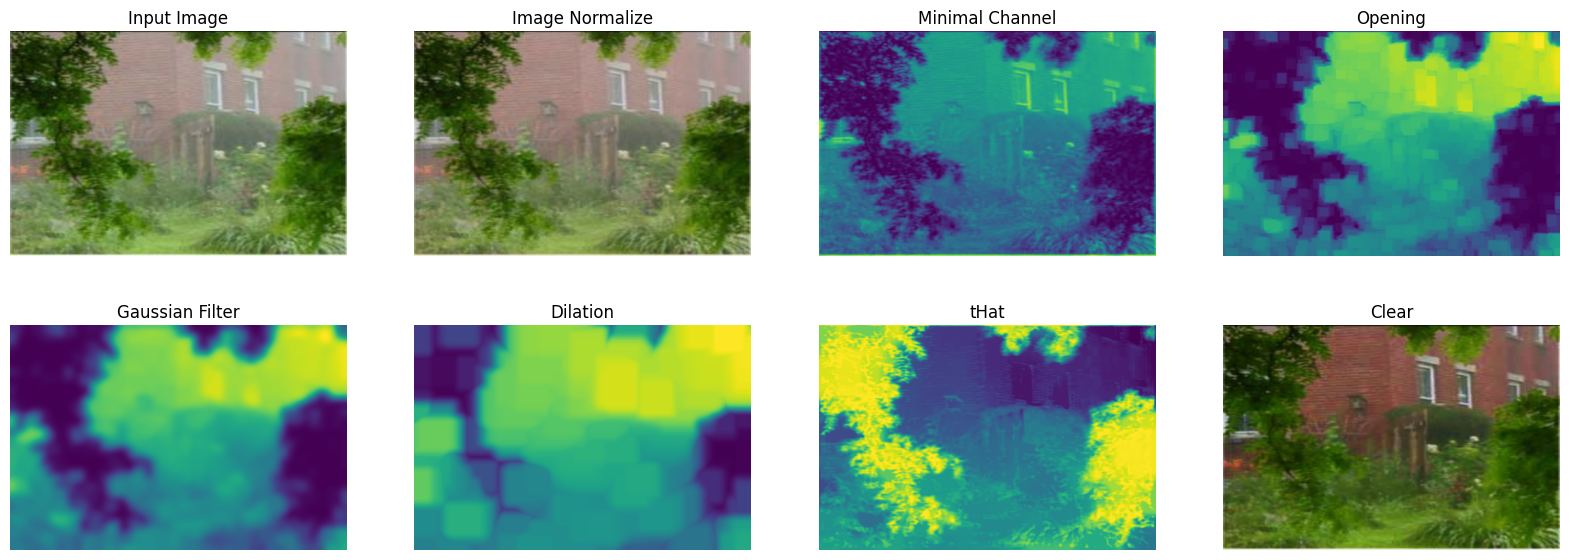

In [9]:
b1 = 15
b2 = 42
g = 37

kernel1 = np.ones((b1, b1), np.uint8)
kernel2 = np.ones((b2, b2), np.uint8)

opening = cv.morphologyEx(minimalChannel, cv.MORPH_OPEN, kernel1)
gaussian = cv.GaussianBlur(opening, (g, g), 0)
dilation = cv.morphologyEx(gaussian, cv.MORPH_DILATE, kernel2)
tHat = 1 - np.minimum(minimalChannel, dilation)

clear = getAtmosphericScatteringModel(image, tHat, atmosphereLight)
# clear = getAtmosphericScatteringModel(image, transmissionMap, atmosphereLight)
clear = cv.normalize(clear, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)


fig = plt.figure(figsize=(20, 7))
rows = 2
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(imageNormalize)
plt.axis('off')
plt.title("Image Normalize")

fig.add_subplot(rows, columns, 3)
plt.imshow(minimalChannel)
plt.axis('off')
plt.title("Minimal Channel")

fig.add_subplot(rows, columns, 4)
plt.imshow(opening)
plt.axis('off')
plt.title("Opening")

fig.add_subplot(rows, columns, 5)
plt.imshow(gaussian)
plt.axis('off')
plt.title("Gaussian Filter")

fig.add_subplot(rows, columns, 6)
plt.imshow(dilation)
plt.axis('off')
plt.title("Dilation")

fig.add_subplot(rows, columns, 7)
plt.imshow(tHat)
plt.axis('off')
plt.title("tHat")

fig.add_subplot(rows, columns, 8)
plt.imshow(clear)
plt.axis('off')
plt.title("Clear")


plt.show()

In [10]:
kernel3 = cv.getGaussianKernel(g, sigma=0)


def conv2d(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape=s, strides=a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

gaussian = conv2d(minimalChannel, kernel3)  # Horizontal
gaussian = conv2d(gaussian, kernel3.T)      # Vertical
gaussian.shape

(364, 564)